In [186]:
import os
import re
import random
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [187]:
image_dir = "../data/plans/with_symbols"

image_list = os.listdir(image_dir)
image_paths = [image_dir + "/" + image_list[i] for i in range(len(image_list))]

#### Extract data from csv label_file (output from label-studio) into two lists:
*   **data** (to be cleaned in the next step)
*   **fnames_labelfile**

In [190]:
label_file = "../data/plans/label_file.csv"

data = []
fnames_labelfile = []

with open(label_file, "r") as f:
    for i, line in enumerate(f):

        if i == 0:
            header = str(line[:-1]).split(",")
            header_dict = {item:k for (k, item) in enumerate(header)}
            data_col = header_dict['label']
            image_path_col = header_dict['image']
            num_cols = max(header_dict.values())
            
            continue

        data.append(str(line).split(",")[data_col:(data_col-num_cols)])

        if image_path_col < data_col:
            fnames_labelfile.append(str(line).split(",")[image_path_col])
        else:
            fnames_labelfile.append(str(line).split(",")[image_path_col-num_cols-1])

        temp_idx = fnames_labelfile[-1].index("plan") # find the position of "plan" to slice the string
        fnames_labelfile[-1] = fnames_labelfile[-1][temp_idx:]

In [191]:
fnames_labelfile

['plan01_2019-02_RFC_38-18197-Rebid-Plans_24.png',
 'plan02_2019-06_05-18241-plans_28.png',
 'plan03_2019-06_15-18158-plans_76.png',
 'plan04_2019-06_RFC_15-18248-plans_14.png',
 'plan05_2019-07_VCSLC_16-18700-plans_96.png',
 'plan06_2019-08_13-18177-plans_70.png',
 'plan07_2019-08_Bexar_0915-12-602_62.png',
 'plan07_2019-08_Bexar_0915-12-602_64.png',
 'plan06_2019-08_13-18177-plans_69b.png']

In [206]:
include_symbols = ["duplex", "quad", "special", "switch"]

data_dict = {}
bbx_id = 0 # this value will be incremented and act as a unique id, in the source data, for all used bounding boxes
for idx, fname in enumerate(fnames_labelfile):

    bbxs = []
    plan_data = data[idx]

    for i in range(0,len(plan_data),8):
        out1 = [float(re.findall("\d+\.\d+", data)[0]) for data in plan_data[i:i+4]] # this grabs the first 4 numnerical values: x, y, width, height

        idx1 = plan_data[i+5].index('["')
        idx2 = plan_data[i+5].index('"]')

        out2 = [plan_data[i+5][idx1+2 : idx2]] # out2 is the class labeled in label-studio
        out3 = [int(re.findall("\d+", data)[0]) for data in plan_data[i+6:i+8]] # this grabs the last 2 numnerical values:original_width, original_height
        # print(out2[0])
        

        if out2[0] in include_symbols:
            out4 = [bbx_id] # this is a unique id for the bounding box
            bbxs.append(out1+out2+out3+[bbx_id])
            bbx_id +=1

    data_dict[fname] = bbxs
    

In [ ]:
data_dict['plan07_2019-08_Bexar_0915-12-602_64.png']

In [193]:
symbol_names = []
for key in data_dict.keys():
    symbol_names.append([val[4] for val in data_dict[key]])

symbol_names2 = [item for sublist in symbol_names for item in sublist]
symbol_names = list(np.unique(symbol_names2))


label_dict = {symbol_names[i]:i for i in range(len(symbol_names))}
label_dict

{'duplex': 0, 'quad': 1, 'special': 2, 'switch': 3}

In [306]:
def get_image_and_bbx_df(fname, pad=0):

    path = image_dir + "/" + fname
    imgfile = Image.open(path)

    df = pd.DataFrame()
    n_bbxs = len(data_dict[fname])

    df['bbx_id'] = [data_dict[fname][i][7] for i in range(n_bbxs)]
    df['type'] = [data_dict[fname][i][4] for i in range(n_bbxs)]
    df['x'] = [data_dict[fname][i][0] for i in range(n_bbxs)]
    df['y'] = [data_dict[fname][i][1] for i in range(n_bbxs)]
    df['w'] = [data_dict[fname][i][2] for i in range(n_bbxs)]
    df['h'] = [data_dict[fname][i][3] for i in range(n_bbxs)]
    df['ow'] = [data_dict[fname][i][5] for i in range(n_bbxs)]
    df['oh'] = [data_dict[fname][i][6] for i in range(n_bbxs)]


    df["xmin"] = np.floor((df['x']/100)*df['ow'])+pad
    df["ymin"] = np.floor((df['y']/100)*df['oh'])+pad

    # df["xmin"] = np.floor((df['x']/100)*df['ow'])
    df["xmax"] = np.ceil(df["xmin"] + (df['w']/100)*df['ow'])
    # df["ymin"] = np.floor((df['y']/100)*df['oh'])
    df["ymax"] = np.ceil(df["ymin"] + (df['h']/100)*df['oh'])
    df["px_width"] = df["xmax"] - df["xmin"]
    df["px_height"] = df["ymax"] - df["ymin"]
    # df["pxw-pxh"] = abs(df["px_width"]-df["px_height"])
    df["pxw-pxh_1"] =-1* np.floor(abs(df["px_width"]-df["px_height"])/2)
    df["pxw-pxh_2"] = abs(df["px_width"]-df["px_height"])+df["pxw-pxh_1"]

    df["x_is_wider"] = df["px_width"]/df["px_height"]
    df["x_is_wider"] = df["x_is_wider"].apply(lambda x: 1 if x>=1 else 0)


    xmin_sq = []
    xmax_sq = []
    ymin_sq = []
    ymax_sq = []

    for index, row in df.iterrows():
        if row["x_is_wider"] == 0:
            xmin_sq.append(row["xmin"]+row["pxw-pxh_1"])
            xmax_sq.append(row["xmax"]+row["pxw-pxh_2"])
            ymin_sq.append(row["ymin"])
            ymax_sq.append(row["ymax"])
        else:
            xmin_sq.append(row["xmin"])
            xmax_sq.append(row["xmax"])
            ymin_sq.append(row["ymin"]+row["pxw-pxh_1"])
            ymax_sq.append(row["ymax"]+row["pxw-pxh_2"])

    df["xmin_sq"] = xmin_sq
    df["xmax_sq"] = xmax_sq
    df["ymin_sq"] = ymin_sq
    df["ymax_sq"] = ymax_sq


    # df.index = df.bbx_id.values
    # df.drop(columns="bbx_id", inplace=True)

    if pad != 0:
        w,h = imgfile.size
        paddedimg = Image.new('RGBA', (w+2*pad, h+2*pad), color='white')
        paddedimg.paste(imgfile, (pad, pad), imgfile)

        return paddedimg, df


    return imgfile, df

## Test get_image_and_bbx_df

showing bbx_id for each bounding box

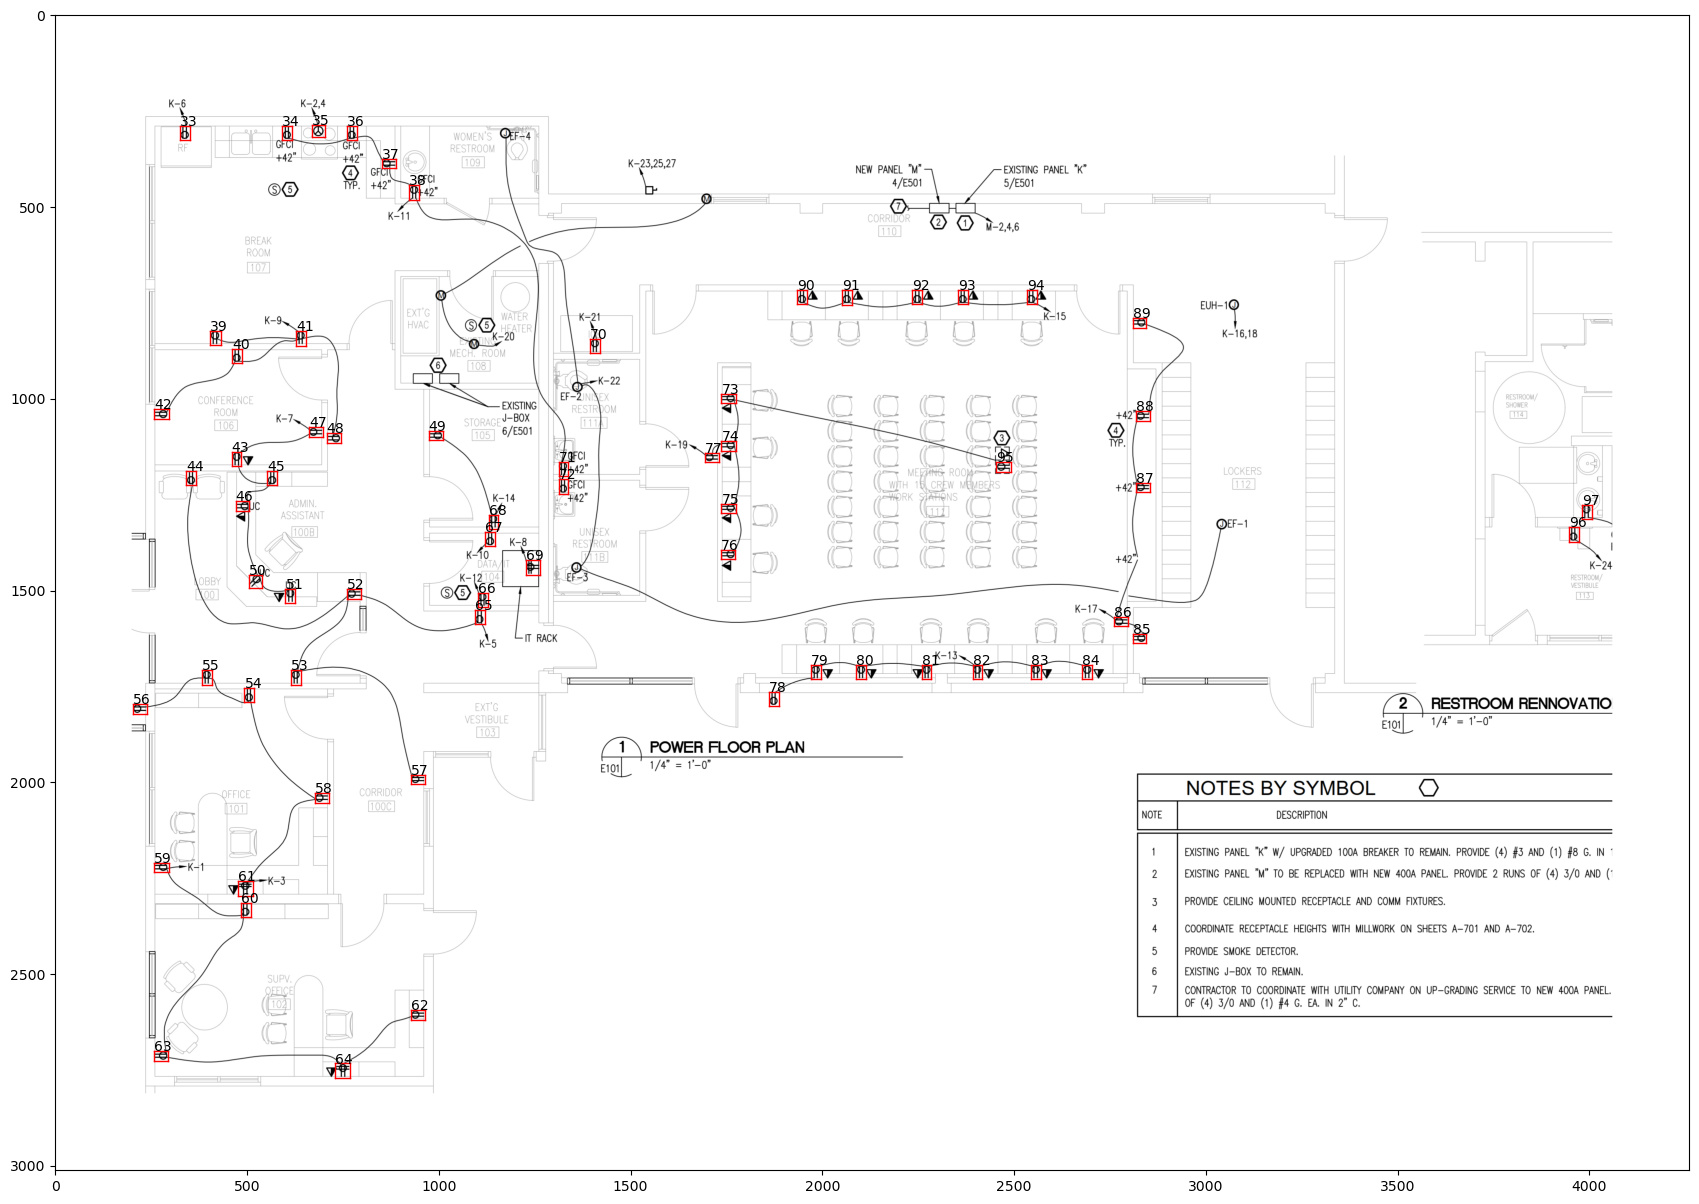

,bbx_id,type,x,y,w,h,ow,oh,xmin,ymin,...,ymax,px_width,px_height,pxw-pxh_1,pxw-pxh_2,x_is_wider,xmin_sq,xmax_sq,ymin_sq,ymax_sq
0,33,duplex,3.223133,3.379699,0.696356,1.440046,3861,2612,324.0,288.0,...,326.0,27.0,38.0,-5.0,6.0,0,319.0,357.0,288.0,326.0
1,34,duplex,10.146901,3.350311,0.656564,1.440046,3861,2612,591.0,287.0,...,325.0,26.0,38.0,-6.0,6.0,0,585.0,623.0,287.0,325.0
2,35,special,12.176281,3.320922,0.835627,1.204936,3861,2612,670.0,286.0,...,318.0,33.0,32.0,-0.0,1.0,1,670.0,703.0,286.0,319.0
3,36,duplex,14.523995,3.350311,0.656564,1.440046,3861,2612,760.0,287.0,...,325.0,26.0,38.0,-6.0,6.0,0,754.0,792.0,287.0,325.0
4,37,duplex,16.898579,6.671233,0.948029,0.931651,3861,2612,852.0,374.0,...,399.0,37.0,25.0,-6.0,6.0,1,852.0,889.0,368.0,405.0
5,38,duplex,18.717294,9.300543,0.685812,1.421647,3861,2612,922.0,442.0,...,480.0,27.0,38.0,-5.0,6.0,0,917.0,955.0,442.0,480.0
6,39,duplex,5.284501,23.836654,0.677898,1.424112,3861,2612,404.0,822.0,...,860.0,27.0,38.0,-5.0,6.0,0,399.0,437.0,822.0,860.0
7,40,duplex,6.765218,25.627885,0.652012,1.404996,3861,2612,461.0,869.0,...,906.0,26.0,37.0,-5.0,6.0,0,456.0,493.0,869.0,906.0
8,41,duplex,11.082632,23.814171,0.653423,1.462861,3861,2612,627.0,822.0,...,861.0,26.0,39.0,-6.0,7.0,0,621.0,660.0,822.0,861.0
9,42,duplex,1.494866,31.688190,0.962327,0.978553,3861,2612,257.0,1027.0,...,1053.0,38.0,26.0,-6.0,6.0,1,257.0,295.0,1021.0,1059.0


In [442]:
imgfile, df = get_image_and_bbx_df(fnames_labelfile[1],pad=200)
imgfile_array = np.array(imgfile)

plt.figure(figsize=(25,15))

plt.imshow(imgfile_array)
for idx, row in df.iterrows():
    plt.plot([row['xmin'], row['xmax']], [row['ymin'], row['ymin']], color='red', linewidth=1)
    plt.plot([row['xmin'], row['xmin']], [row['ymax'], row['ymin']], color='red', linewidth=1)
    plt.plot([row['xmax'], row['xmax']], [row['ymax'], row['ymin']], color='red', linewidth=1)
    plt.plot([row['xmin'], row['xmax']], [row['ymax'], row['ymax']], color='red', linewidth=1)
    plt.annotate(row['bbx_id'], (row['xmin'], row['ymin']))
# plt.xticks([])
# plt.yticks([])

plt.show()

df.head(10)

### Check size (pixels) of symbols on the plans

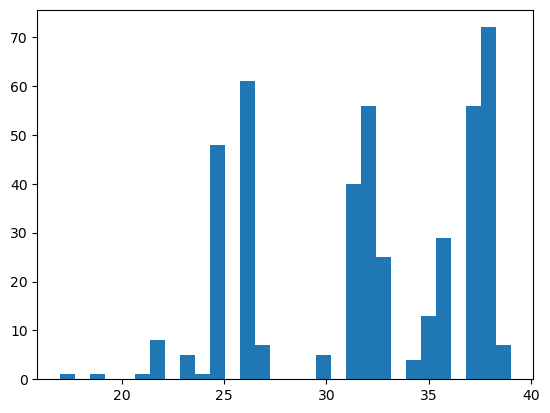

In [196]:
px_w = []
px_h = []

for fname in fnames_labelfile:
    _, df = get_image_and_bbx_df(fname)
    px_w.append(df['px_width'].values)
    px_h.append(df['px_height'])

px_w = [value for sublist in px_w for value in sublist]
px_h = [value for sublist in px_h for value in sublist]

px_max = [max(px_w[i], px_h[i]) for i in range(len(px_w))]

plt.hist(px_max, bins=30)
plt.show()

In [443]:
def get_crop(img_array, img_bbx_data, crop_size, x1, y1, max_transl, intersect_padding):

    x2 = x1+crop_size
    y2 = y1+crop_size

    # start by validating the crop, making sure it's actually in the image
    def validate_crop(x1, x2, y1, y2):
        if x2 > img_array.shape[1]:
            x1 = img_array.shape[1] - crop_size
            x2 = img_array.shape[1]
            # print("crop not ok")
            # print(f"new x1 value: {x1}")

        if y2>img_array.shape[0]:
            y1 = img_array.shape[0] - crop_size
            y2 = img_array.shape[0]
            # print("crop not ok")
            # print(f"new y1 value: {y1}")
 
        return x1, x2, y1, y2
    

    # check if the edges of the crop intersect a symbol
    def check_intersect(x1=x1, x2=x2, y1=y1, y2=y2):
        for index, row in img_bbx_data.iterrows():

            if (row["xmin"]-intersect_padding < x1 < row["xmax"]+intersect_padding) or \
            (row["xmin"]-intersect_padding < x2 < row["xmax"]+intersect_padding) or \
            (row["ymin"]-intersect_padding < y1 < row["ymax"]+intersect_padding) or \
            (row["ymin"]-intersect_padding < y2 < row["ymax"]+intersect_padding):
                
                return True # the edges of the current crop intersects at least 1 symbol
            
        return False
    

    def constrain_translation(x1, x2, y1, y2):
        transl_multip = [-1, 1, -1, 1]

        if x1 == 0: # currently at the left edge of the image
            transl_multip[0] = 0

        if x2 == img_array.shape[1]: # crop currently outside the right edge of the image
            transl_multip[1] = 0

        if y1 == 0: # currently scanning top edge of image
            transl_multip[2] = 0

        if y2 == img_array.shape[0]: # crop currently outside the right edge of the image
            transl_multip[3] = 0
        
        return transl_multip
    

    def get_symbols_in_crop():

        idxs = []       
        for index, row in img_bbx_data.iterrows():
            if ((x1 < row["xmin"]) and (x2 > row["xmax"])) and ((y1 < row["ymin"]) and (y2 > row["ymax"])):
                idxs.append(index)  # note that index here HAS TO BE rownumber in the current dataframe


        df = img_bbx_data.iloc[idxs, ::].copy()
        df.loc[:,'xmin'] = df['xmin'] -x1
        df.loc[:,'xmax'] = df['xmax'] -x1
        df.loc[:,'ymin'] = df['ymin'] -y1
        df.loc[:,'ymax'] = df['ymax'] -y1
        df['crop_size'] = crop_size

        df = df[['bbx_id', 'type', 'xmin', 'xmax', 'ymin', 'ymax', 'crop_size']]

        return df


    # ensure the crop is in the image
    x1, x2, y1, y2 = validate_crop(x1, x2, y1, y2)


    if check_intersect():

        transl_multip = constrain_translation(x1, x2, y1, y2)

        # set candidate variables
        x1c = x1
        x2c = x2
        y1c = y1
        y2c = y2

        p=0.25
        p_add=0.25
        
        i = 0

        while True:
            
            # always create new candidates from the original x1, y1

            # constrain the random ranges so that the magnitude of the attempted translation consistently increases 
            # with more iterations

            try:
                x_negative_randint = np.random.randint(transl_multip[0]*p*max_transl, transl_multip[0]*(p-p_add)*max_transl)
            except:
                x_negative_randint = 0

            try:
                x_positive_randint = np.random.randint(transl_multip[1]*(p-p_add)*max_transl, transl_multip[1]*(p)*max_transl)
            except:
                x_positive_randint = 0

            x_randint = random.choice([x_negative_randint, x_positive_randint])
            x1c = x1 + x_randint


            try:
                y_negative_randint = np.random.randint(transl_multip[2]*p*max_transl, transl_multip[2]*(p-p_add)*max_transl)
            except:
                y_negative_randint = 0

            try:
                y_positive_randint = np.random.randint(transl_multip[3]*(p-p_add)*max_transl, transl_multip[3]*(p)*max_transl)
            except:
                y_positive_randint = 0

            y_randint = random.choice([y_negative_randint, y_positive_randint])
            y1c = y1 + y_randint




            # x1c = x1 + np.random.randint(transl_multip[0]*p*max_transl, transl_multip[1]*p*max_transl)                        
            x2c = x1c + crop_size
            # y1c = y1 + np.random.randint(transl_multip[2]*p*max_transl, transl_multip[3]*p*max_transl)
            y2c = y1c + crop_size

            # validate candidates
            x1c, x2c, y1c, y2c = validate_crop(x1c, x2c, y1c, y2c)

            # check so that they don't intersect
            if check_intersect(x1c, x2c, y1c, y2c) == False:
                x1 = x1c
                x2 = x2c
                y1 = y1c
                y2 = y2c


                crop_img = img_array[y1:y2, x1:x2, ::]
                crop_bbx_data = get_symbols_in_crop()
                # print(i, p, x1, y1)

                break

            if p < 1 and i%800 == 0: # increment p by p0 every 800th iteration
                p += p_add

            if i == 3000:
                print("cannot find a crop without intersecting any symbol(s)")
                x1 = -1
                y1 = -1
                crop_img = np.array([[[255, 255, 255]]]) # one white pixel
                crop_bbx_data = pd.DataFrame()

                break

            i +=1
    else:
        crop_img = img_array[y1:y2, x1:x2, ::]
        crop_bbx_data = get_symbols_in_crop()


    return x1, y1, crop_img, crop_bbx_data


In [578]:
def get_crop2(img_array, img_bbx_data, crop_size, x1, y1, max_transl, intersect_padding, seed_nr=0, print_on=False):

    x1_input = x1
    y1_input = y1

    x2 = x1+crop_size
    y2 = y1+crop_size

    # start by validating the crop, making sure it's actually in the image
    def validate_crop(x1, x2, y1, y2):
        if x2 > img_array.shape[1]:
            x1 = img_array.shape[1] - crop_size
            x2 = img_array.shape[1]
            # print("crop not ok")
            # print(f"new x1 value: {x1}")

        if y2>img_array.shape[0]:
            y1 = img_array.shape[0] - crop_size
            y2 = img_array.shape[0]
            # print("crop not ok")
            # print(f"new y1 value: {y1}")
 
        return x1, x2, y1, y2
    

    # # check if the edges of the crop intersect a symbol
    # def check_intersect(x1=x1, x2=x2, y1=y1, y2=y2):
    #     for index, row in img_bbx_data.iterrows():

    #         if (row["xmin"]-intersect_padding < x1 < row["xmax"]+intersect_padding) or \
    #         (row["xmin"]-intersect_padding < x2 < row["xmax"]+intersect_padding) or \
    #         (row["ymin"]-intersect_padding < y1 < row["ymax"]+intersect_padding) or \
    #         (row["ymin"]-intersect_padding < y2 < row["ymax"]+intersect_padding):
                
    #             return True # the edges of the current crop intersects at least 1 symbol
            
    #     return False



    # check if the edges of the crop intersect a symbol
    def check_intersect(x1=x1, x2=x2, y1=y1, y2=y2):
        for index, row in img_bbx_data.iterrows():

            if ((row["xmin"]-intersect_padding < x1 < row["xmax"]+intersect_padding) or \
                    (row["xmin"]-intersect_padding < x2 < row["xmax"]+intersect_padding)) and \
                ((row["ymin"] > y1+intersect_padding) and (row["ymax"] < y2-intersect_padding)):
                
                return True # one of the the current crops VERTICAL edges intersect at least 1 symbol
            
            if ((row["ymin"]-intersect_padding < y1 < row["ymax"]+intersect_padding) or \
                    (row["ymin"]-intersect_padding < y2 < row["ymax"]+intersect_padding)) and \
                ((row["xmin"] > x1+intersect_padding) and (row["xmax"] < x2-intersect_padding)):
                
                return True # one of the the current crops HORIZONTAL edges intersect at least 1 symbol
            
        return False
    

    def constrain_translation(x1, x2, y1, y2):
        transl_multip = [-1, 1, -1, 1]

        if x1 == 0: # currently at the left edge of the image
            transl_multip[0] = 0

        if x2 == img_array.shape[1]: # crop currently outside the right edge of the image
            transl_multip[1] = 0

        if y1 == 0: # currently scanning top edge of image
            transl_multip[2] = 0

        if y2 == img_array.shape[0]: # crop currently outside the right edge of the image
            transl_multip[3] = 0
        
        return transl_multip
    

    def get_symbols_in_crop():

        idxs = []       
        for index, row in img_bbx_data.iterrows():
            if ((x1 < row["xmin"]) and (x2 > row["xmax"])) and ((y1 < row["ymin"]) and (y2 > row["ymax"])):
                idxs.append(index)  # note that index here HAS TO BE rownumber in the current dataframe


        df = img_bbx_data.iloc[idxs, ::].copy()
        df.loc[:,'xmin'] = df['xmin'] -x1
        df.loc[:,'xmax'] = df['xmax'] -x1
        df.loc[:,'ymin'] = df['ymin'] -y1
        df.loc[:,'ymax'] = df['ymax'] -y1
        df['crop_size'] = crop_size

        df = df[['bbx_id', 'type', 'xmin', 'xmax', 'ymin', 'ymax', 'crop_size']]

        return df
    


    def print_resulting_crop_details(x1, y1, df, seed_nr, counter=0, x1_input=x1_input, y1_input=y1_input):
        x_delta = x1-x1_input
        y_delta = y1-y1_input

        print(f"seed nr={str(seed_nr).zfill(3)}, iter={counter},\tdx={x_delta},   \tdy={y_delta},   \tn symbols={len(df)}, \tstart xy({x1_input},{y1_input}),   \tnew xy({x1},{y1})")




    # ensure the crop is in the image
    x1, x2, y1, y2 = validate_crop(x1, x2, y1, y2)

    i = 0
    if check_intersect():

        transl_multip = constrain_translation(x1, x2, y1, y2)

        # set candidate variables
        x1c = x1
        x2c = x2
        y1c = y1
        y2c = y2

        p=0.25
        p_add=0.25
        
        

        while True:
            
            # always create new candidates from the original x1, y1

            # constrain the random ranges so that the magnitude of the attempted translation consistently increases 
            # with more iterations

            try:
                x_negative_randint = [np.random.randint(transl_multip[0]*p*max_transl, transl_multip[0]*(p-p_add)*max_transl)]
            except:
                x_negative_randint = []

            try:
                x_positive_randint = [np.random.randint(transl_multip[1]*(p-p_add)*max_transl, transl_multip[1]*(p)*max_transl)]
            except:
                x_positive_randint = []

            x_randint = random.choice(x_negative_randint+x_positive_randint)
            x1c = x1 + x_randint


            try:
                y_negative_randint = [np.random.randint(transl_multip[2]*p*max_transl, transl_multip[2]*(p-p_add)*max_transl)]
            except:
                y_negative_randint = []

            try:
                y_positive_randint = [np.random.randint(transl_multip[3]*(p-p_add)*max_transl, transl_multip[3]*(p)*max_transl)]
            except:
                y_positive_randint = []

            y_randint = random.choice(y_negative_randint+y_positive_randint)
            y1c = y1 + y_randint




            # x1c = x1 + np.random.randint(transl_multip[0]*p*max_transl, transl_multip[1]*p*max_transl)                        
            x2c = x1c + crop_size
            # y1c = y1 + np.random.randint(transl_multip[2]*p*max_transl, transl_multip[3]*p*max_transl)
            y2c = y1c + crop_size

            # validate candidates
            x1c, x2c, y1c, y2c = validate_crop(x1c, x2c, y1c, y2c)

            # check so that they don't intersect
            if check_intersect(x1c, x2c, y1c, y2c) == False:
                x1 = x1c
                x2 = x2c
                y1 = y1c
                y2 = y2c


                crop_img = img_array[y1:y2, x1:x2, ::]
                crop_bbx_data = get_symbols_in_crop()
                # print(i, p, x1, y1)

                break


            if p < 1 and i%1000 == 0: # increase p by p0 every 1000th iteration
                p += p_add


            if i == 5000:  # maximum number of iterations
                # print("cannot find a crop without intersecting any symbol(s)")
                # x1 = -1
                # y1 = -1
                # crop_img = np.array([[[255, 255, 255]]]) # one white pixel



                # create crop anyways but return an empty dataframe to indicate that this seed location did not result in a crop with bbxs
                x1 = x1c
                x2 = x2c
                y1 = y1c
                y2 = y2c

                crop_img = img_array[y1:y2, x1:x2, ::]  
                crop_bbx_data = pd.DataFrame()

                break

            i +=1
    else:
        crop_img = img_array[y1:y2, x1:x2, ::]
        crop_bbx_data = get_symbols_in_crop()
    
    
    if print_on == True:
        print_resulting_crop_details(x1=x1, y1=y1, df=crop_bbx_data, seed_nr=seed_nr, counter=i)

    return x1, y1, crop_img, crop_bbx_data


### Test the get_crop function

Start by getting the image and the associated df with the bounding box data

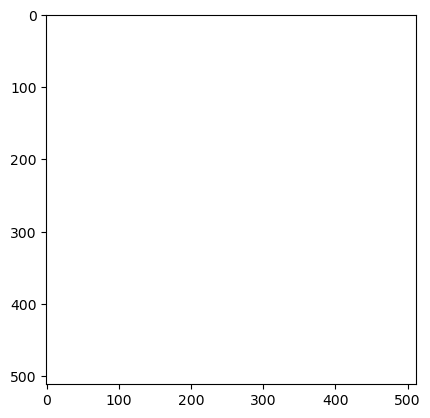

In [600]:
x1, y1, out_img, crop_bbx_data = get_crop2(img_array=imgfile_array, img_bbx_data=df, crop_size=512, x1=1000, y1=10, max_transl=200, intersect_padding=3)
# x1, y1, out_img, crop_bbx_data = get_crop(img_array=imgfile_array, img_bbx_data=df, crop_size=512, x1=0, y1=1718, max_transl=75, intersect_padding=5)
plt.imshow(out_img)
plt.show()

In [601]:
crop_bbx_data

,bbx_id,type,xmin,xmax,ymin,ymax,crop_size


In [559]:
def generate_crop_seeds(img_array, crop_size, target_overlap):

    x1 = []
    y1 = []

    xmax = img_array.shape[1]-crop_size
    ymax = img_array.shape[0]-crop_size

    nx_steps = int(np.ceil(xmax/(crop_size*(1-target_overlap))))
    ny_steps = int(np.ceil(ymax/(crop_size*(1-target_overlap))))
    x = list(np.linspace(0, xmax, nx_steps+1))
    y = list(np.linspace(0, ymax, ny_steps+1))

    overlap = (round(1-x[1]/crop_size,2), round(1-y[1]/crop_size,2))

    for yval in y:
        for xval in x:
            x1.append(int(round(xval, 0)))
            y1.append(int(round(yval, 0)))


    return x1, y1, overlap

#### Test the generate_crop_seeds function

nr. of seed locations: 1488
resulting overlap: (0.85, 0.85)


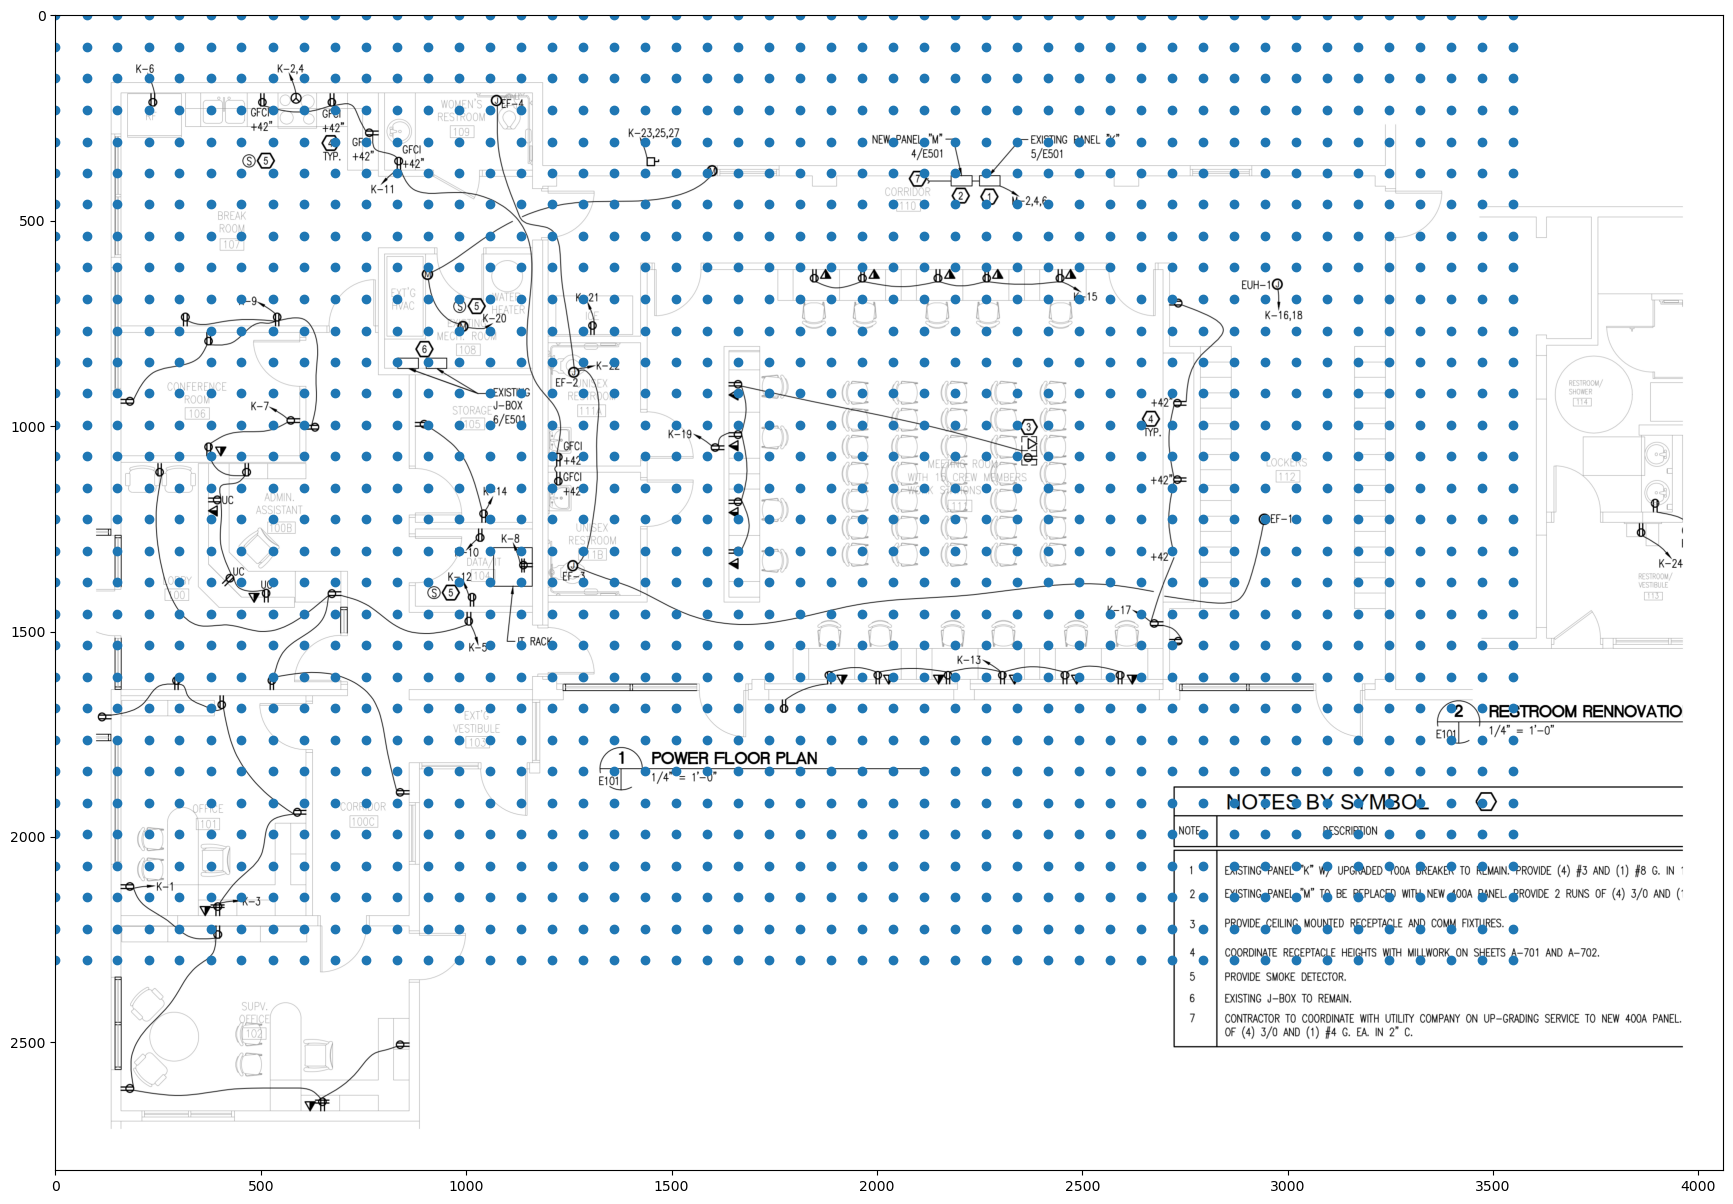

In [649]:
crop_size=512

x1, y1, overlap =generate_crop_seeds(img_array=imgfile_array, crop_size=512, target_overlap=0.85)
print("nr. of seed locations:", len(x1))
print("resulting overlap:", overlap)

plt.figure(figsize=(25,15))
plt.imshow(imgfile_array)
plt.scatter(x1,y1)
plt.show()

#### Generate crops and show them if they contain symbols (max crops displayed = n)

seed nr=001, iter=0,	dx=0,   	dy=0,   	n symbols=1, 	start xy(0,0),   	new xy(0,0)
seed nr=002, iter=0,	dx=0,   	dy=0,   	n symbols=5, 	start xy(496,0),   	new xy(496,0)
seed nr=003, iter=0,	dx=0,   	dy=0,   	n symbols=0, 	start xy(992,0),   	new xy(992,0)
seed nr=004, iter=0,	dx=0,   	dy=0,   	n symbols=0, 	start xy(1488,0),   	new xy(1488,0)
seed nr=005, iter=0,	dx=0,   	dy=0,   	n symbols=2, 	start xy(0,500),   	new xy(0,500)
seed nr=006, iter=0,	dx=0,   	dy=0,   	n symbols=1, 	start xy(496,500),   	new xy(496,500)
seed nr=007, iter=0,	dx=0,   	dy=0,   	n symbols=1, 	start xy(992,500),   	new xy(992,500)
seed nr=008, iter=1,	dx=-14,   	dy=13,   	n symbols=2, 	start xy(1488,500),   	new xy(1474,513)
seed nr=009, iter=3,	dx=24,   	dy=-22,   	n symbols=4, 	start xy(0,1000),   	new xy(24,978)
seed nr=010, iter=2,	dx=17,   	dy=-23,   	n symbols=4, 	start xy(496,1000),   	new xy(513,977)
seed nr=011, iter=5,	dx=-25,   	dy=-22,   	n symbols=6, 	start xy(992,1000),   	new xy(967,978)
seed n

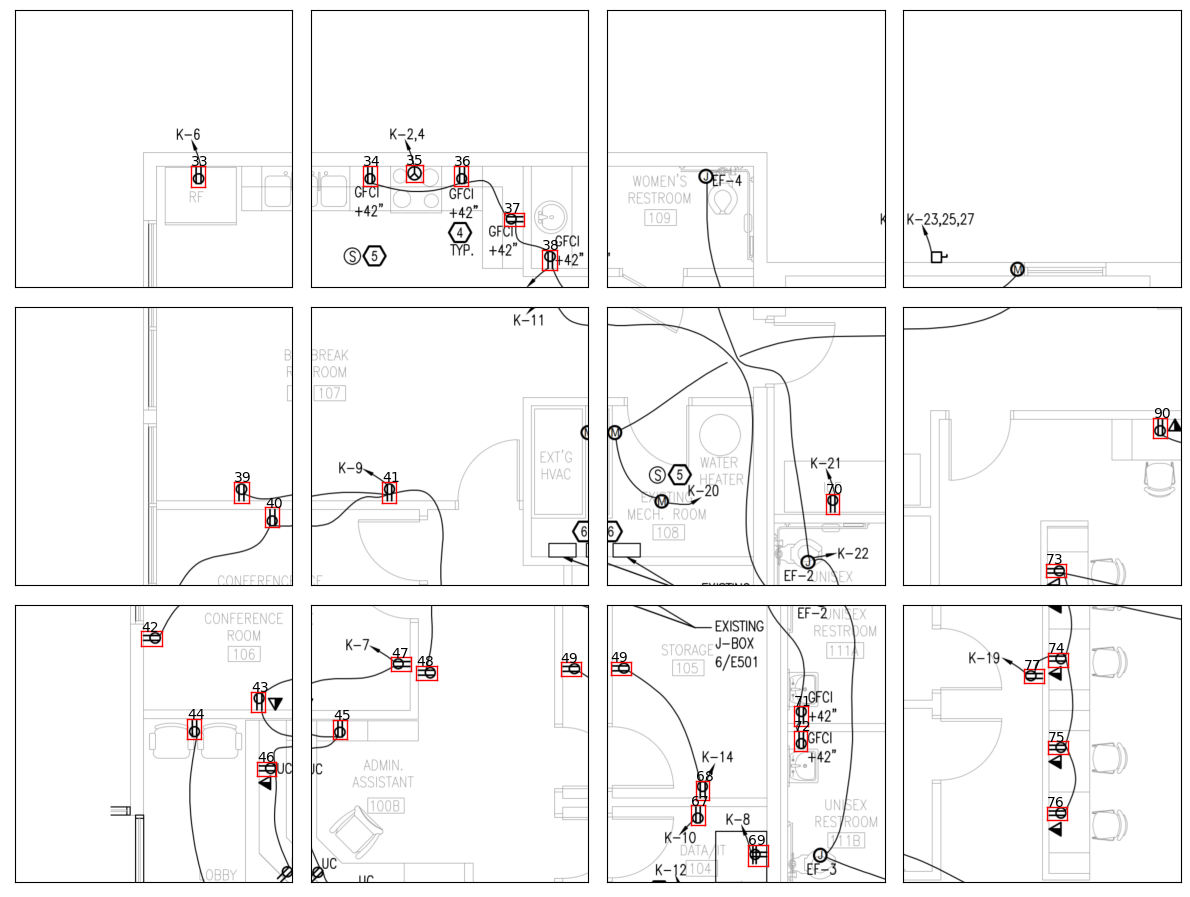

In [566]:
n = 12
crop_size=512

imgfile_array_mod = imgfile_array[:, :2000, ::]  # take only the leftmost 2000 pixels

x_seed, y_seed, overlap =generate_crop_seeds(img_array=imgfile_array_mod, crop_size=crop_size, target_overlap=0)


plt.figure(figsize=(12,12))
j=1
for i in range(len(x_seed)):
    # print(x_seed[i], y_seed[i])
    _, _, out_img, crop_bbx_data = get_crop2(print_on=True, seed_nr=i+1, img_array=imgfile_array_mod, img_bbx_data=df, crop_size=crop_size, x1=x_seed[i], y1=y_seed[i], max_transl=50, intersect_padding=3)

    if crop_bbx_data.empty == False:
        plt.subplot(4,4,j)
        plt.imshow(out_img)
        for idx, row in crop_bbx_data.iterrows():
            plt.plot([row['xmin'], row['xmax']], [row['ymin'], row['ymin']], color='red', linewidth=1)
            plt.plot([row['xmin'], row['xmin']], [row['ymax'], row['ymin']], color='red', linewidth=1)
            plt.plot([row['xmax'], row['xmax']], [row['ymax'], row['ymin']], color='red', linewidth=1)
            plt.plot([row['xmin'], row['xmax']], [row['ymax'], row['ymax']], color='red', linewidth=1)
            plt.annotate(row['bbx_id'], (row['xmin'], row['ymin']))
        plt.xticks([])
        plt.yticks([])

        j+=1


    if crop_bbx_data.empty == True:  # show empty crop
        plt.subplot(4,4,j)
        plt.imshow(out_img)
        plt.xticks([])
        plt.yticks([])

        j+=1

    if j>n:
        break    

plt.tight_layout()

#### Save (up to) n crops + yolo label-files (.txt)

In [656]:
empty_samples_frac = 0.2
n_max = 9999
img_pad = 100
max_crop_transl = 75
crop_size=512
crop_intersect_padding = 2
target_overlap = 0.6
output_dir = "../_ignore/manually_labeled_training/_temp_output_dir/"
output_df = pd.DataFrame()


os.makedirs(output_dir+"labels_manual/")
os.makedirs(output_dir+"images_manual/")


j_not_empty = 0 
j_empty = 0
for fname in fnames_labelfile:
# for fname in ['plan07_2019-08_Bexar_0915-12-602_64.png']:

    imgfile, df = get_image_and_bbx_df(fname, pad=img_pad)
    imgfile_array = np.array(imgfile)

    x_seed, y_seed, overlap =generate_crop_seeds(img_array=imgfile_array, crop_size=crop_size, target_overlap=target_overlap)
    # print(fname, overlap)

    for i in range(len(x_seed)):
        j = j_not_empty + j_empty
        _, _, out_img, crop_bbx_data = get_crop2(img_array=imgfile_array, img_bbx_data=df, crop_size=crop_size, x1=x_seed[i], y1=y_seed[i], max_transl=max_crop_transl, intersect_padding=crop_intersect_padding)

        if crop_bbx_data.empty == False:

            crop_img_name = str(j).zfill(4) + "_" + fname[:6] + ".png"

            crop_bbx_data["image"] = crop_img_name
            crop_bbx_data["image_id"] = j
            crop_bbx_data["has_annotation"] = True
            crop_bbx_data["class_id"] = crop_bbx_data["type"].apply(lambda x: label_dict[x])
            output_df = pd.concat([output_df, crop_bbx_data], axis=0, ignore_index=True)

            img_output_path = output_dir + "images_manual/" + crop_img_name
            txt_output_path = output_dir + "labels_manual/" + crop_img_name[:-4] + ".txt."

            temp_image = Image.fromarray(out_img)
            temp_image.save(img_output_path)

            with open(txt_output_path, mode="w") as f:
                k=1
                for idx, row in crop_bbx_data.iterrows():
                    x1rel = (row['xmin']+row['xmax'])/2/row['crop_size']
                    y1rel = (row['ymin']+row['ymax'])/2/row['crop_size']
                    wrel = (row['xmax']-row['xmin'])/row['crop_size']
                    hrel = (row['ymax']-row['ymin'])/row['crop_size']
                    label = label_dict[row['type']]

                    f.write(f"{label} {x1rel} {y1rel} {wrel} {hrel}")

                    if k!= len(crop_bbx_data):
                        f.write("\n")
                    k+=1       
            j_not_empty+=1

        if crop_bbx_data.empty == True:

            if j_empty < j_not_empty*empty_samples_frac:

                crop_img_name = str(j).zfill(4) + "e_" + fname[:6] + ".png"

                crop_bbx_data =crop_bbx_data.append({"image":crop_img_name,
                                                     "image_id":j,
                                                     "has_annotation":"False",
                                                     "crop_size":crop_size,
                                                     "class_id":-1}, ignore_index=True)
                
                output_df = pd.concat([output_df, crop_bbx_data], axis=0, ignore_index=True)

                img_output_path = output_dir + "images_manual/" + crop_img_name
                txt_output_path = output_dir + "labels_manual/" + crop_img_name[:-4] + ".txt."

                temp_image = Image.fromarray(out_img)
                temp_image.save(img_output_path)

                with open(txt_output_path, mode="w") as f:
                    f.write("\n")
    
                j_empty+=1
            
        if j > n_max:
            break

output_df.to_csv(output_dir + "manually_labeled_images.csv", index=False)

In [657]:
print(j, j_not_empty, j_empty)

795 662 133


In [658]:
output_df2 = output_df[output_df["class_id"]!=-1]
allbbxs = sorted(list(output_df2["bbx_id"]))
min_bbx = int(min(allbbxs))
max_bbx = int(max(allbbxs))

[i for i in list(range(min_bbx, max_bbx)) if i not in allbbxs]


bbxs_not_present = [i for i in list(range(min_bbx, max_bbx)) if i not in allbbxs]
len(bbxs_not_present)

0

[]


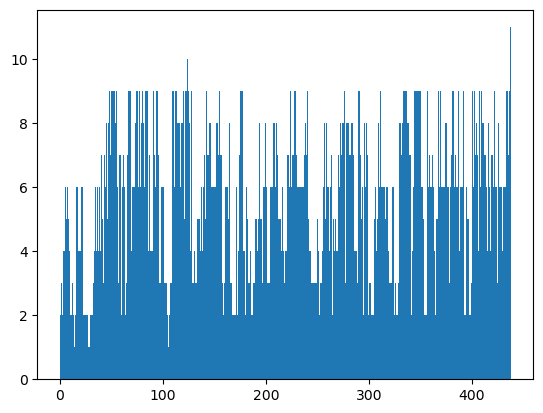

In [662]:
print(bbxs_not_present)
plt.hist(allbbxs, bins=list(range(min_bbx, max_bbx)))
plt.show()

In [185]:
# split into train, valid and test folders
train_split = 0.5
valid_split = 0.3
test_split = 0.2

os.makedirs(output_dir+"train/images")
os.makedirs(output_dir+"train/labels")
os.makedirs(output_dir+"valid/images")
os.makedirs(output_dir+"valid/labels")
os.makedirs(output_dir+"test/images")
os.makedirs(output_dir+"test/labels")

imagelist = os.listdir(output_dir+"images")
labellist = os.listdir(output_dir+"labels")
n = len(imagelist)
print(f"Partitioning {n} images into train, valid, and test")

idx_set = [i for i in range(0,n)]
idx_train_set = random.sample(idx_set, int(n*train_split))
idx_set = [i for i in idx_set if i not in idx_train_set]
idx_valid_set = random.sample(idx_set, int(n*valid_split))
idx_test_set = [i for i in idx_set if i not in idx_valid_set]

for idx in idx_train_set:
    os.rename(output_dir+"images/"+imagelist[idx], output_dir+"train/images/"+imagelist[idx])
    os.rename(output_dir+"labels/"+labellist[idx], output_dir+"train/labels/"+labellist[idx])
for idx in idx_valid_set:
    os.rename(output_dir+"images/"+imagelist[idx], output_dir+"valid/images/"+imagelist[idx])
    os.rename(output_dir+"labels/"+labellist[idx], output_dir+"valid/labels/"+labellist[idx])
for idx in idx_test_set:
    os.rename(output_dir+"images/"+imagelist[idx], output_dir+"test/images/"+imagelist[idx])
    os.rename(output_dir+"labels/"+labellist[idx], output_dir+"test/labels/"+labellist[idx])

os.rmdir(output_dir+"images/")
os.rmdir(output_dir+"labels/")

Partitioning 2509 images into train, valid, and test


In [ ]:
# imgfiles = os.listdir(output_dir+ "images/")


# train = random.sample(imgfiles, 800)
# test = [imgfile for imgfile in imgfiles if imgfile not in train]
# print("total image count:", len(imgfiles))
# print(len(train))
# print(len(test))


# with open(output_dir + "train.txt", 'w') as f:
#     for filename in train:
#         string = "./data/images/" + filename + "\n"
#         f.write(string)

# f.close()

# with open(output_dir + "valid.txt", 'w') as f:
#     for filename in test:
#         string = "./data/images/" + filename + "\n"
#         f.write(string)

# f.close()

In [10]:
def plot_symbols(fname, symbol_size):
    imgfile, df = get_image_and_bbx_df(fname)
    imgfile_array = np.array(imgfile)

    print("image file:", fname)
    print("image dimensions:", imgfile_array.shape)

    n_items = len(df)
    nw = 8
    nh = int(np.ceil(n_items/nw))

    plt.figure(figsize=((symbol_size*2),round((symbol_size*2*nh)/nw,1)))

    for i in range(n_items):
        xmin = int(df.iloc[i,16])
        xmax = int(df.iloc[i,17])
        ymin = int(df.iloc[i,18])
        ymax = int(df.iloc[i,19])

        cropped_img_array = imgfile_array[ymin:ymax, xmin:xmax, ::]
        plt.subplot(nh, nw, i+1)
        plt.imshow(cropped_img_array)
        plt.title(f"{i}: {df.iloc[i,0]}")
        plt.axis("off")
    plt.tight_layout()

image file: plan01_2019-02_RFC_38-18197-Rebid-Plans_24.png
image dimensions: (2340, 2548, 4)


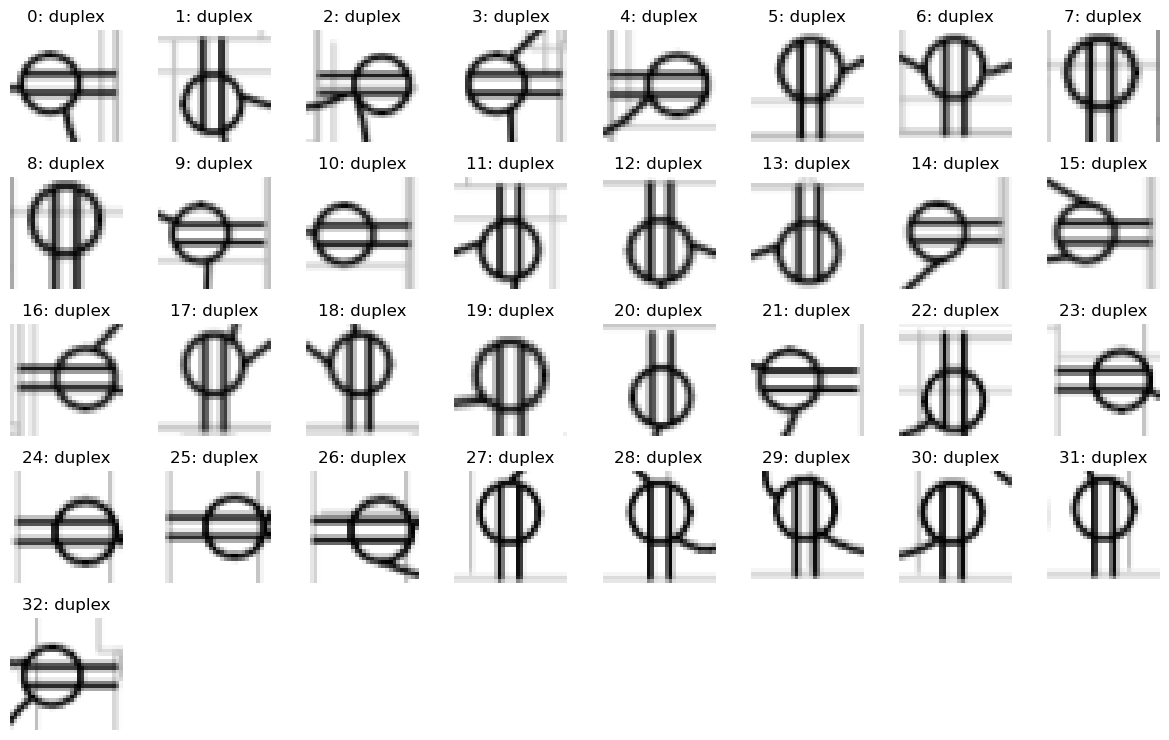

In [236]:
plot_symbols(fnames_labelfile[0], symbol_size=6)

image file: plan02_2019-06_05-18241-plans_28.png
image dimensions: (2612, 3861, 4)


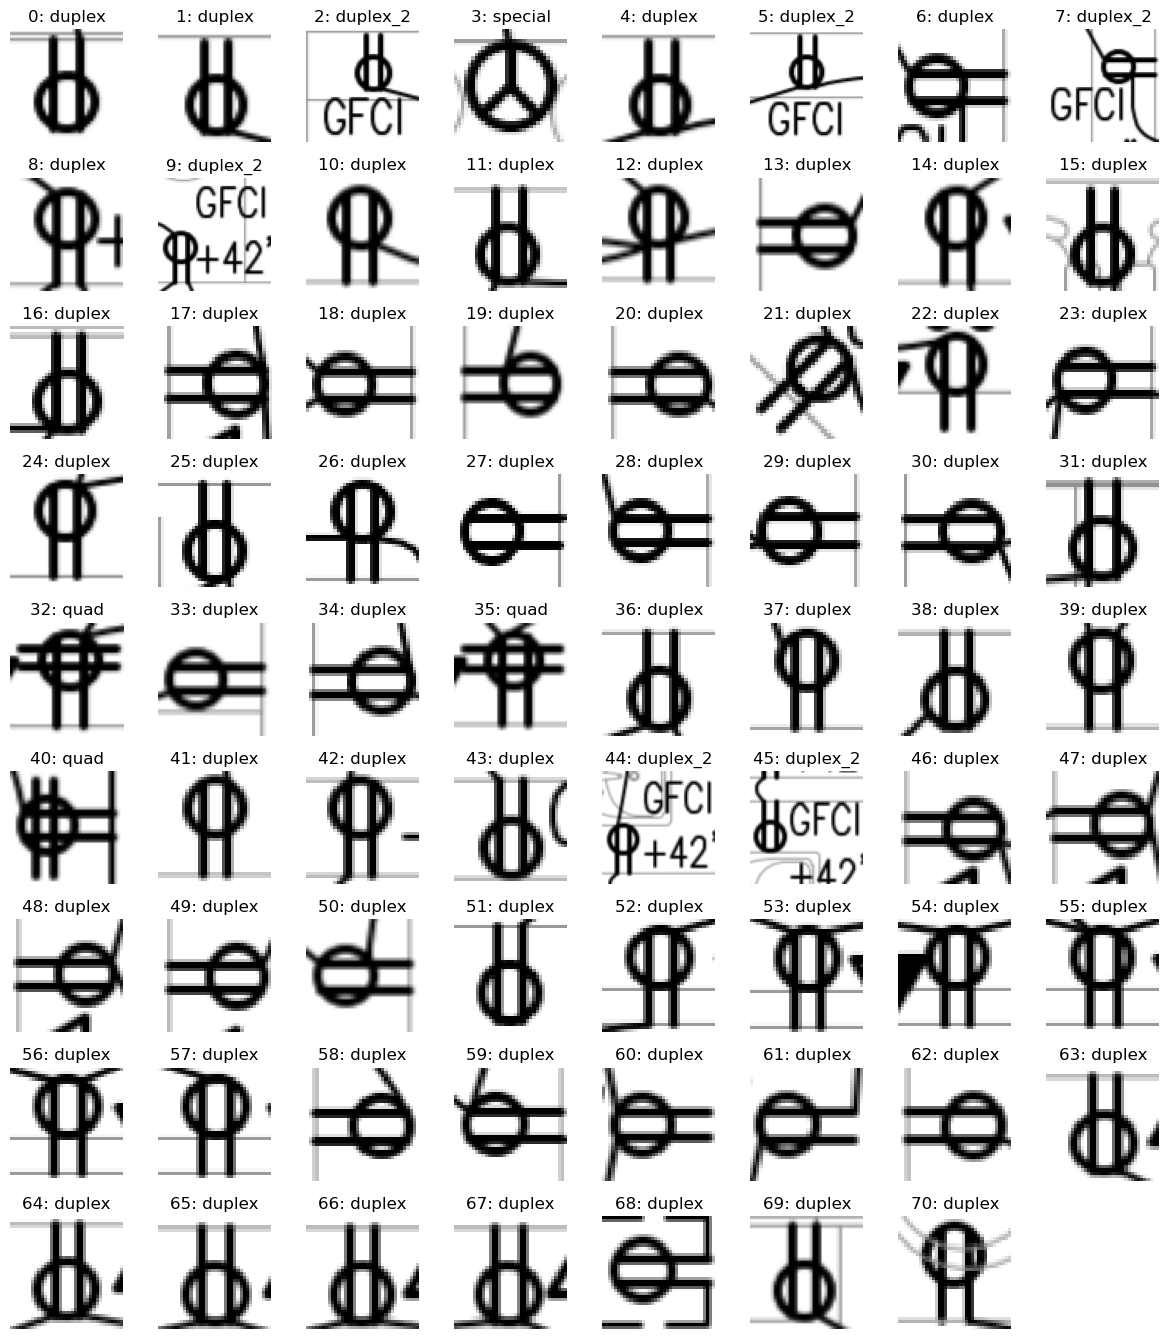

In [237]:
plot_symbols(fnames_labelfile[1], symbol_size=6)

image file: plan03_2019-06_15-18158-plans_76.png
image dimensions: (1222, 2365, 4)


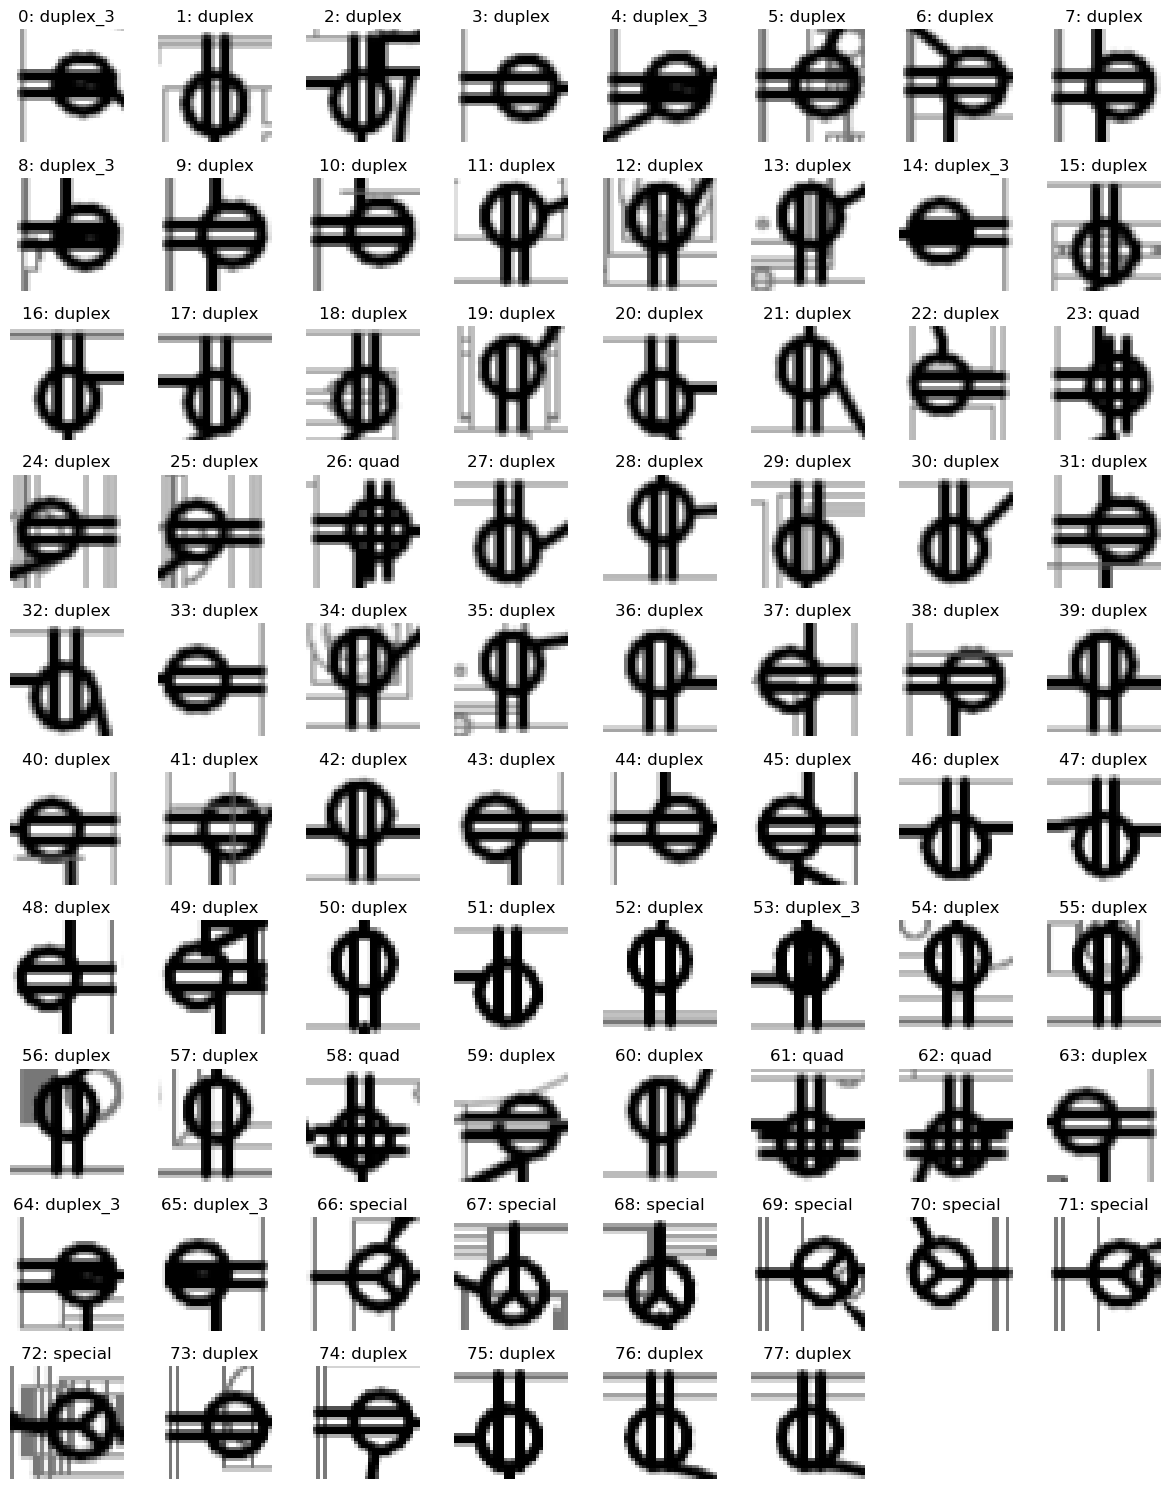

In [238]:
plot_symbols(fnames_labelfile[2], symbol_size=6)

image file: plan04_2019-06_RFC_15-18248-plans_14.png
image dimensions: (1092, 2381, 4)


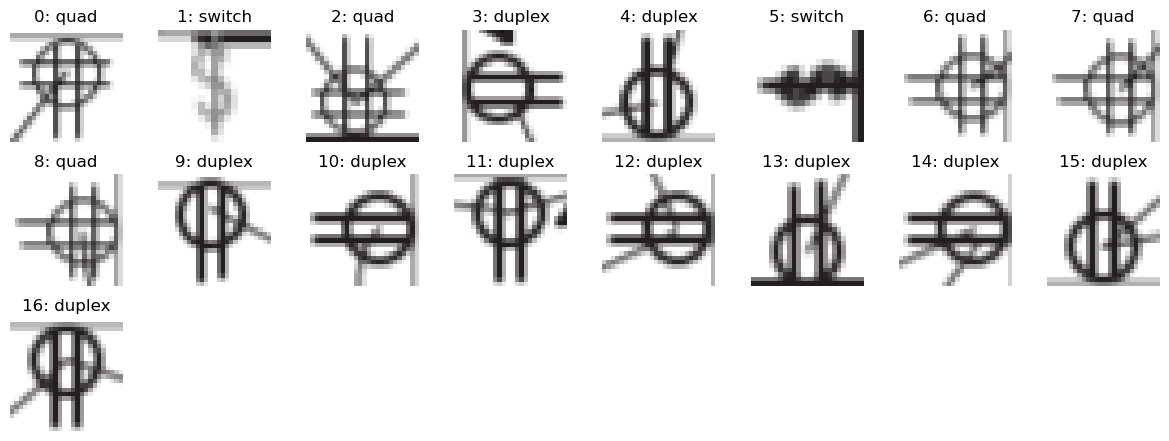

In [239]:
plot_symbols(fnames_labelfile[3], symbol_size=6)

image file: plan05_2019-07_VCSLC_16-18700-plans_96.png
image dimensions: (1644, 3672, 4)


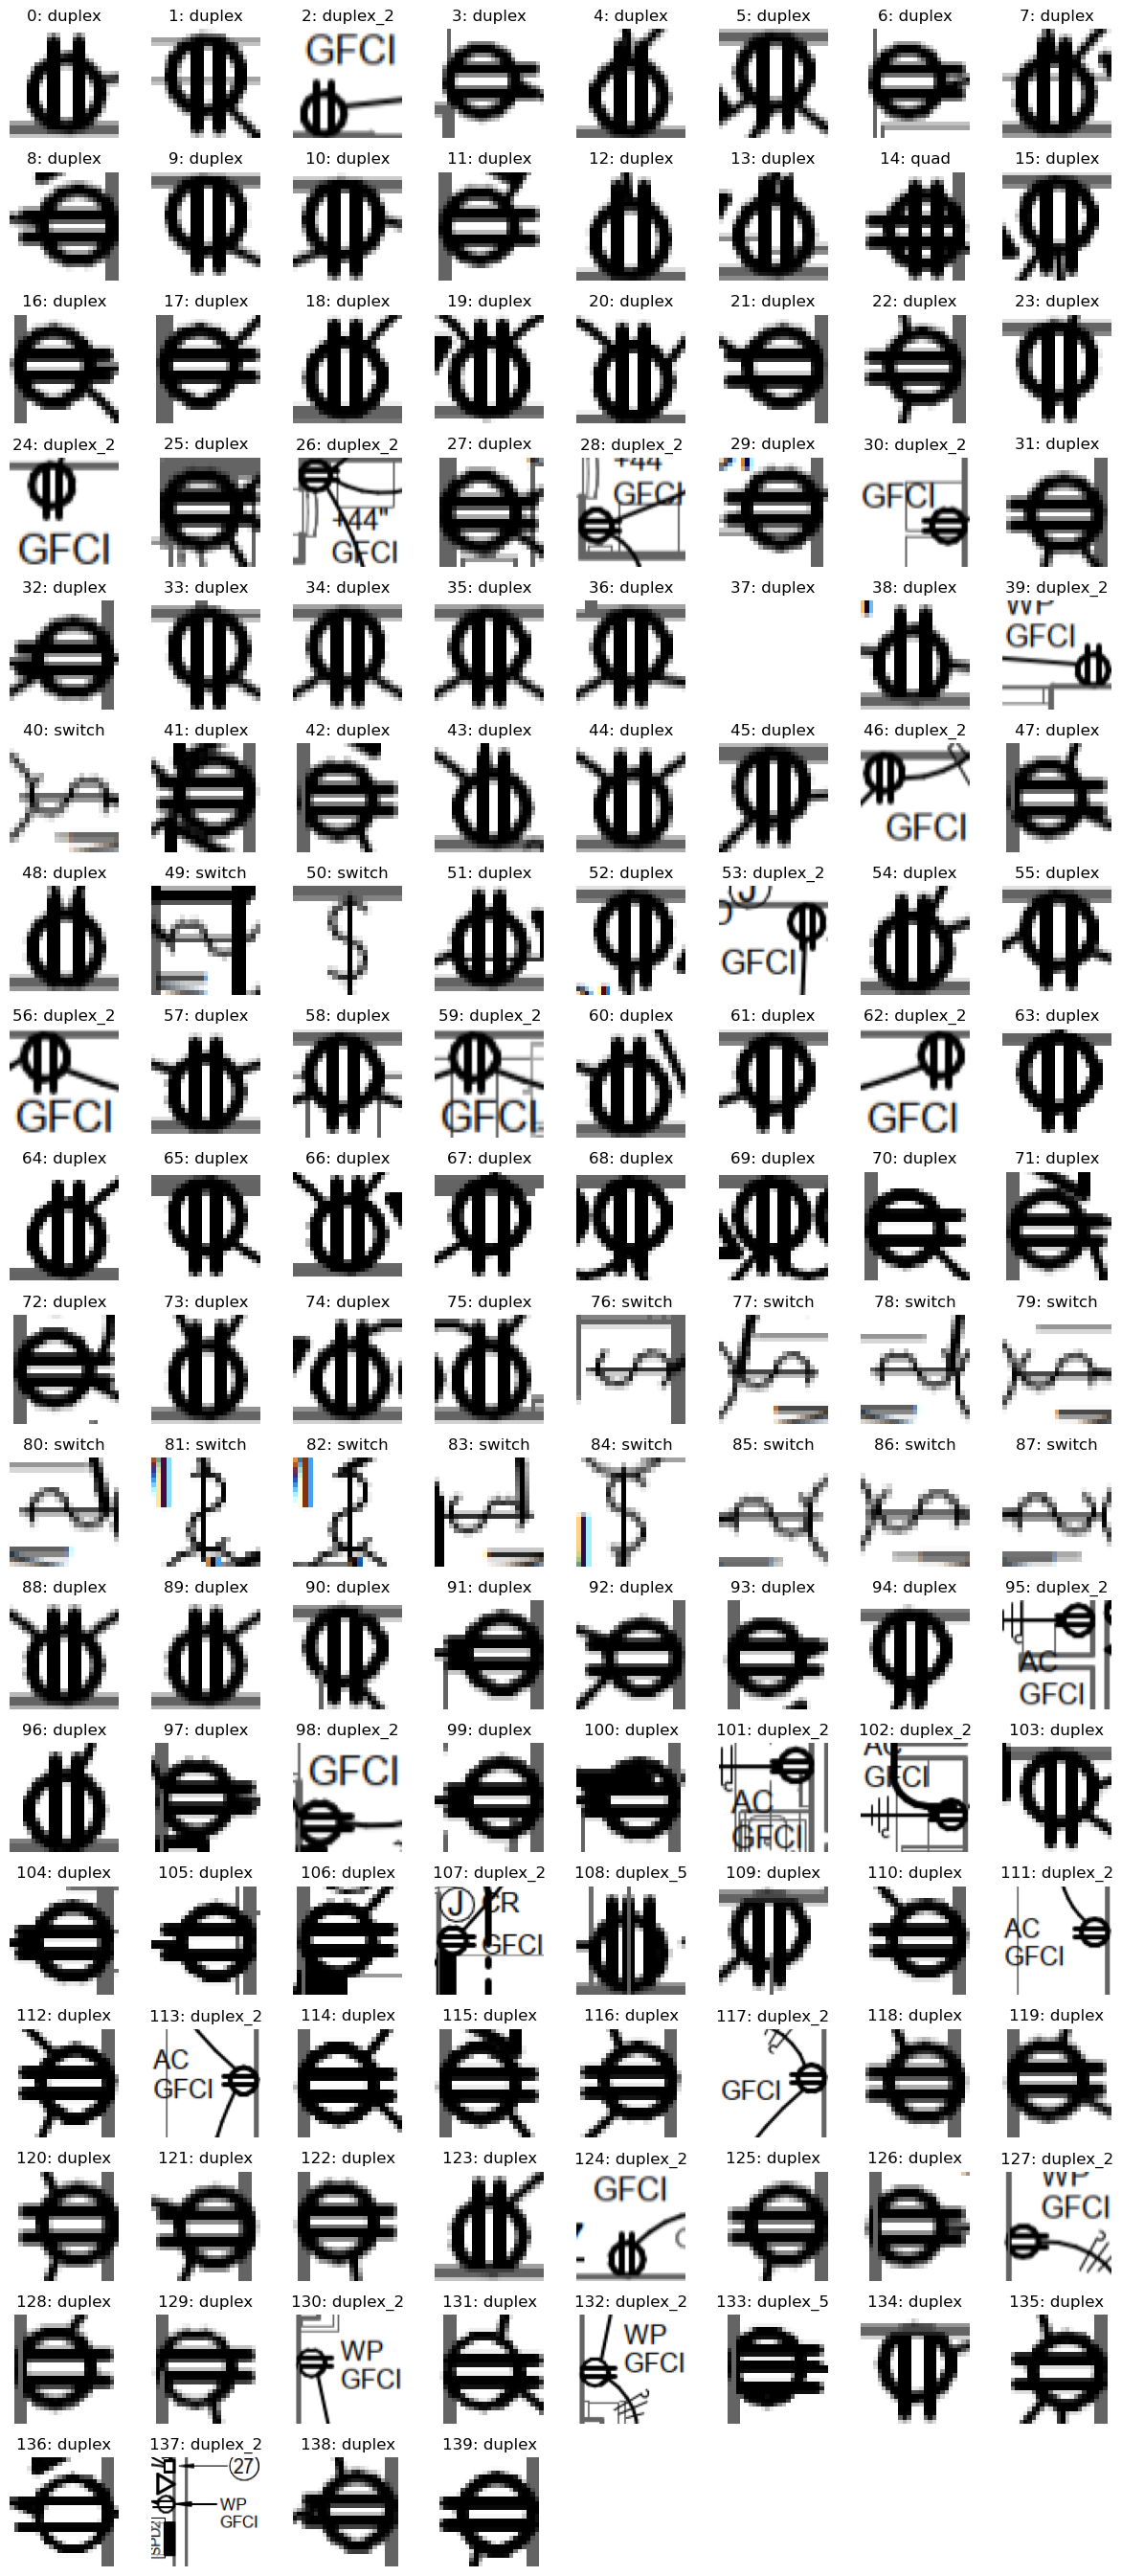

In [240]:
plot_symbols(fnames_labelfile[4], symbol_size=6)

image file: plan06_2019-08_13-18177-plans_70.png
image dimensions: (1923, 1713, 4)


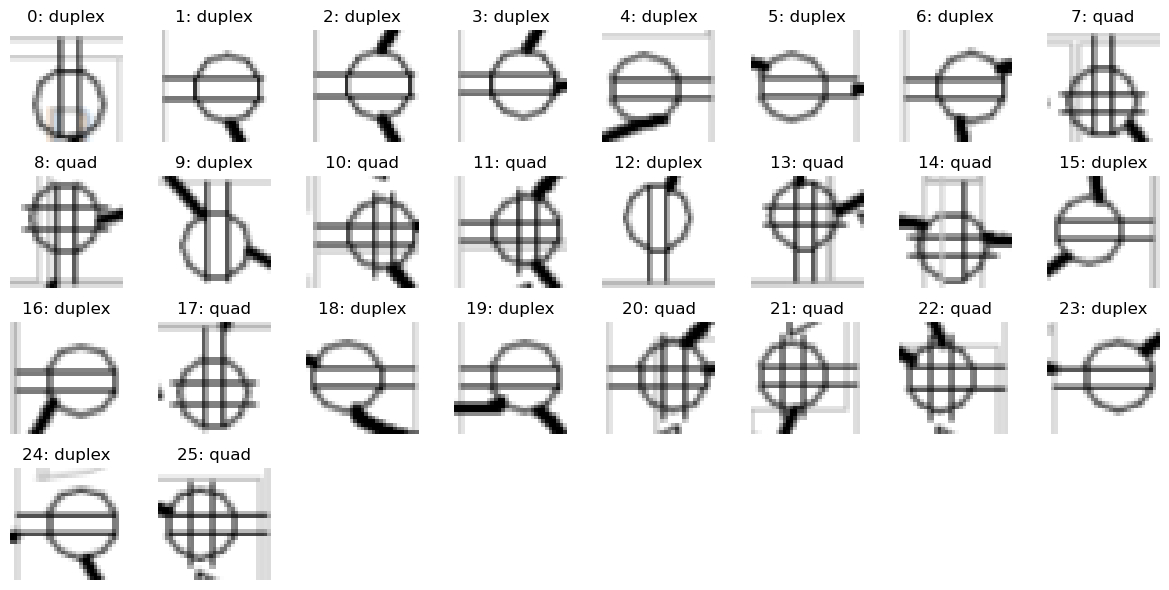

In [241]:
plot_symbols(fnames_labelfile[5], symbol_size=6)

image file: plan07_2019-08_Bexar_0915-12-602_62.png
image dimensions: (1682, 1242, 4)


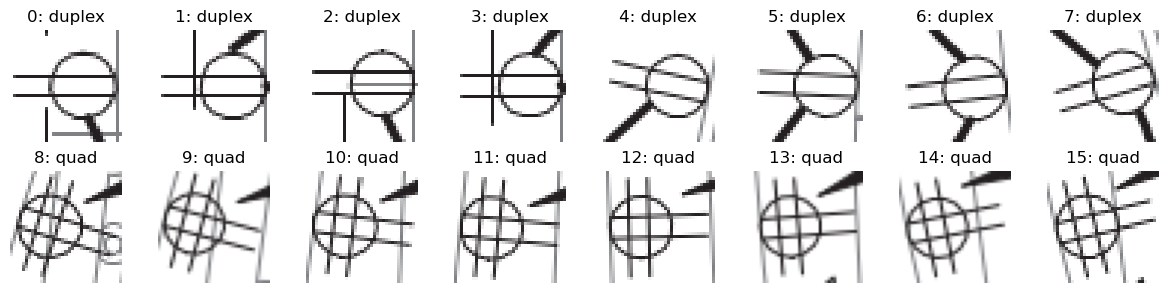

In [242]:
plot_symbols(fnames_labelfile[6], symbol_size=6)

image file: plan08_2019-08_Culberson_0003-01-055_Vol_2_181.png
image dimensions: (1581, 3080, 4)


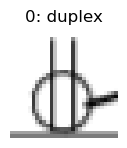

In [243]:
plot_symbols(fnames_labelfile[7], symbol_size=6)

In [ ]:
# labeling not completed for plan08_2019-08_Culberson_0003-01-055_Vol_2_181.png

image file: plan06_2019-08_13-18177-plans_69b.png
image dimensions: (2573, 5429, 4)


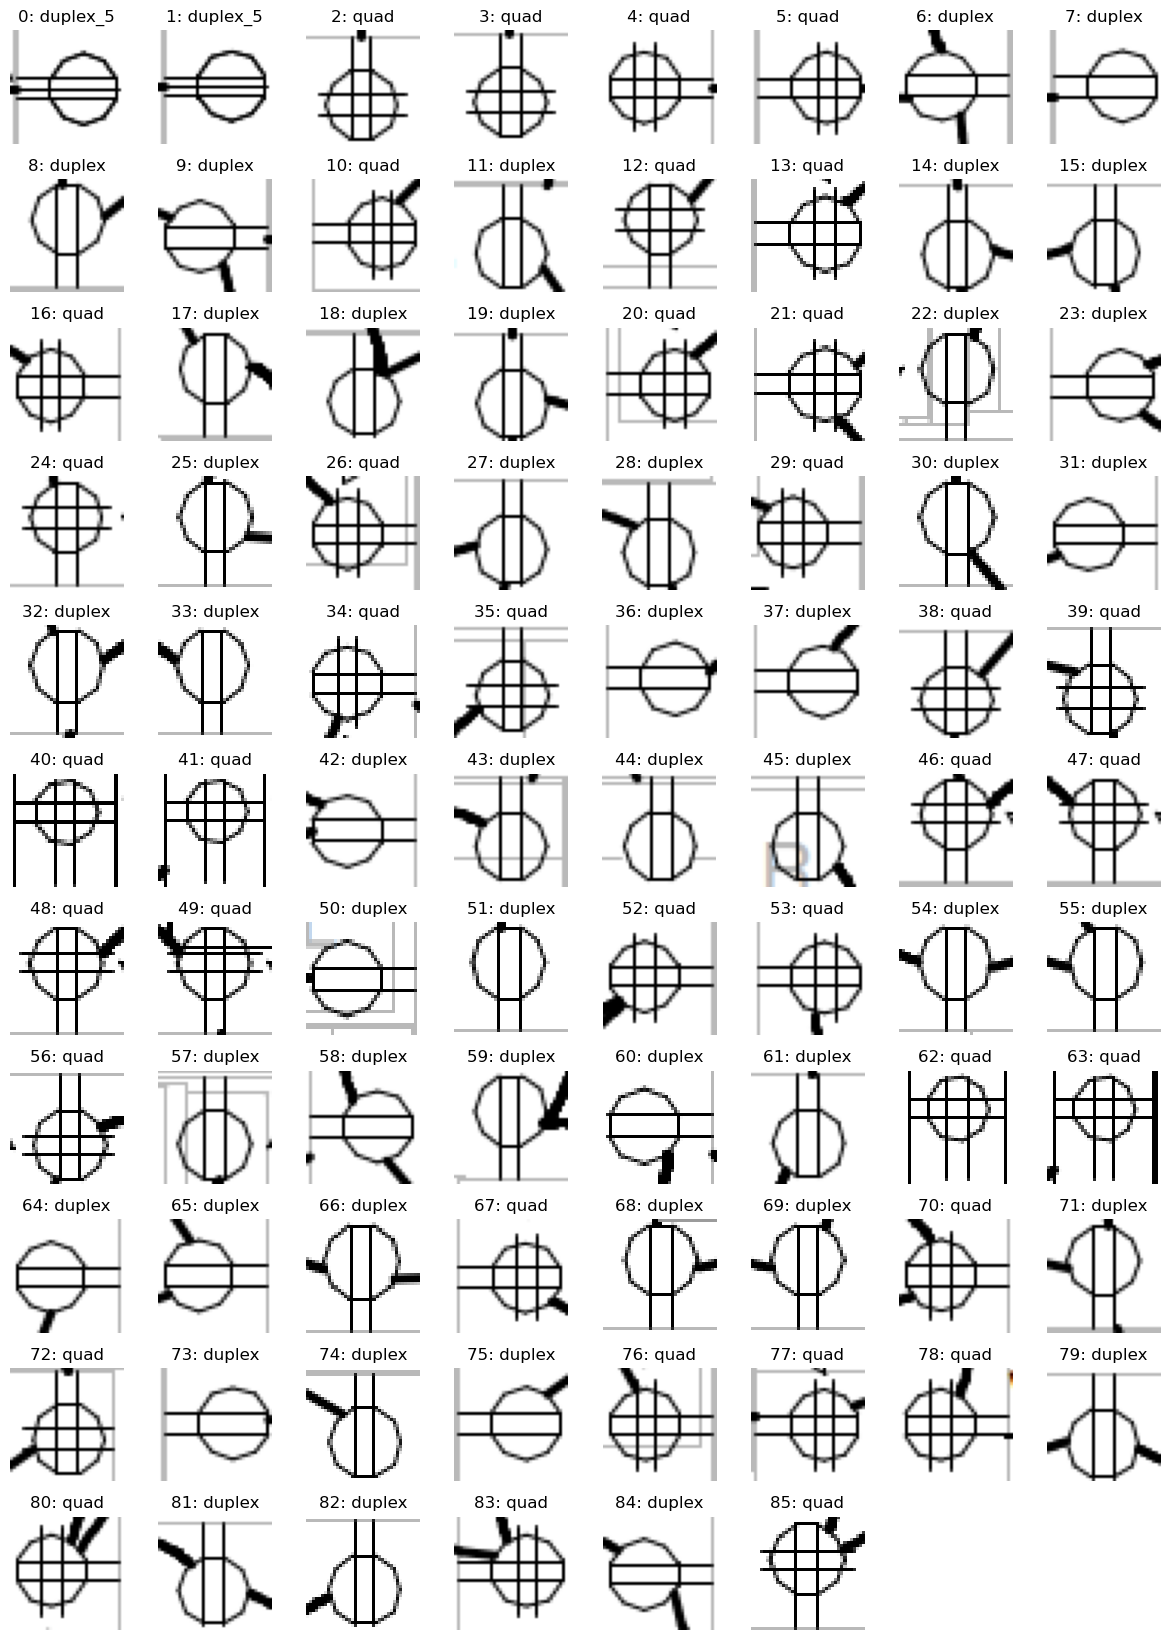

In [244]:
plot_symbols(fnames_labelfile[8], symbol_size=6)

In [245]:
plot_symbols(fnames_labelfile[9], symbol_size=6)

IndexError: list index out of range